In [8]:
import numpy as np  
import glob as glob
import os

# read in files to a dictionary based on file name results/{LABEL}_r{MUTANTID}_model_md.interactions.log
def read_files(files):
    data = {}
    for file in files:
        #label = os.path.basename(file).split('_')[0]
        #mutantid = file.split('_')[1][1:]
        #data[label + ":"+mutantid] = np.loadtxt(file, skiprows=1)
        label = "_".join(  os.path.basename(file).split("_")[:2] )
        #print(f"parsing {file}")
        try: 
            new_data = np.loadtxt(file, skiprows=1)
        except ValueError as e:
            print(f"Error parsing {file} {e}, skipping)")
            pass
        data[label] = new_data

    return data

results_dir = "output/validation_sequences_9Feb2025"

# read in the files from the results directory
files = glob.glob(os.path.join(results_dir,"*/*/md_implicit/*.interactions.log"))
data = read_files(files)


parsing output/validation_sequences_9Feb2025/q4vgl6/q4vgl6_mut2/md_implicit/q4vgl6_mut2_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/q4vgl6/q4vgl6_mut5/md_implicit/q4vgl6_mut5_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/q4vgl6/q4vgl6_mut3/md_implicit/q4vgl6_mut3_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/q4vgl6/q4vgl6_ref/md_implicit/q4vgl6_ref_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/p04891/p04891_mut3/md_implicit/p04891_mut3_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/p04891/p04891_mut9/md_implicit/p04891_mut9_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/p04891/p04891_mut8/md_implicit/p04891_mut8_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/p04891/p04891_mut5/md_implicit/p04891_mut5_model_md.interactions.log
parsing output/validation_sequences_9Feb2025/p04891/p04891_mut1/md_implicit/p04891_mut1_mo

In [75]:
# get reference data
import pandas as pd
reference_csv_file = "raw_inputs/validation_sequences_9Feb2025.csv"
reference_df = pd.read_csv(reference_csv_file,keep_default_na=False)
# uniprot_id.lower(), wild_G0
reference_energies_dict = {}
reference_nuc_length_dict = {}
name_count_dict = {}
reference_nuc_type_dict = {}
seq_index = {}
for index, row in df.iterrows():
    name = row['uniprot_id'].lower()
    if name not in name_count_dict:
        name_count_dict[name] = 1
        seq_index[name] = len(name_count_dict)
    else:
        name_count_dict[name] += 1

    mutid = name_count_dict[name]
#(seq_index[name], row['ddG'])
    sequence_length = len(row['mutated_nucleotide_strand1'])
    reference_energies_dict[name+"_mut"+str(mutid)] = row['ddG']
    reference_nuc_length_dict[name+"_mut"+str(mutid)] = sequence_length
    reference_nuc_type_dict[name+"_mut"+str(mutid)] = row['nucleotide_sequence_type']

print(reference_energies_dict)

{'p32081_mut1': '0.48', 'p32081_mut2': '0.02', 'p32081_mut3': '0.34', 'p32081_mut4': '0.34', 'p32081_mut5': '0.98', 'p32081_mut6': '1.28', 'p32081_mut7': '0.42', 'p32081_mut8': '0.42', 'p32081_mut9': '0.72', 'q57468_mut1': '-0.43', 'q57468_mut2': '0', 'q57468_mut3': '0', 'q57468_mut4': '1.28', 'q57468_mut5': '0', 'q57468_mut6': '0.85', 'q57468_mut7': '0.85', 'q57468_mut8': '1.28', 'q57468_mut9': '0.85', 'q57468_mut10': '1.28', 'q57468_mut11': '1.28', 'q57468_mut12': '1.28', 'q57468_mut13': '1.28', 'q57468_mut14': '1.28', 'q57468_mut15': '1.28', 'q57468_mut16': '1.28', 'q57468_mut17': '1.28', 'q57468_mut18': '-0.43', 'q57468_mut19': '0', 'p16117_mut1': '-6.17', 'p16117_mut2': '-5.76', 'p16117_mut3': '-5.76', 'p03049_mut1': '3.94', 'p03049_mut2': '2.73', 'p03049_mut3': '2.09', 'p03049_mut4': '3.03', 'p03049_mut5': '2.48', 'p03049_mut6': '3.4', 'p03049_mut7': '3.45', 'p04891_mut1': '-9.9', 'p04891_mut2': '-7.4', 'p04891_mut3': '-7.4', 'p04891_mut4': '1.14', 'p03045_mut1': '0.33', 'p03045_

In [76]:
# loop over keys in data containing 'mut' and check if same mutant has a 'ref' entry
# if so, calculate the difference between the two

# create a pandas data frame with the following columns: uniprot_id, mut_id, ddG, ddG_pred
results_df = pd.DataFrame(columns=['uniprot_id','mut_id','nuc_type','ddG','ddG_measured', 'nuc_length', 'ddG_per'])

for key in data.keys():
    if key.find('mut')>0:
        uniprot_id = key.split('_')[0]
        ref_key = "_".join([uniprot_id,'ref'])

        if ref_key in data:
            mutant_data = data[key]
            ref_data = data[ref_key]
            mut_avg_energy = np.mean(mutant_data[:,-1])
            ref_avg_energy = np.mean(ref_data[:,-1])
            ddG = mut_avg_energy - ref_avg_energy
            ddG_kcal = ddG/4.184
            mut_id = int(key.split('_')[1].replace("mut",""))
            ddG_measured = reference_energies_dict[key]
            nuc_length = reference_nuc_length_dict[key]
            nuc_type = reference_nuc_type_dict[key]
            if len(ddG_measured)>0:
                results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'nuc_length':nuc_length, 'ddG_per': ddG_kcal/float(nuc_length)},ignore_index=True)
            else:
                print(f"no ddG for {key}")
    else:
        pass

/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'nuc_length':nuc_length, 'ddG_per': ddG_kcal/float(nuc_length)},ignore_index=True)
/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'nuc_length':nuc_length, 'ddG_per': ddG_kcal/float(nuc_length)},ignore_index=True)
/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resul

no ddG for p03332_mut2
no ddG for p03332_mut1
no ddG for p03332_mut4
no ddG for p03332_mut3
no ddG for p03332_mut5


/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'nuc_length':nuc_length, 'ddG_per': ddG_kcal/float(nuc_length)},ignore_index=True)
/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'uniprot_id':uniprot_id,'mut_id':mut_id,'nuc_type':nuc_type, 'ddG':ddG_kcal,'ddG_measured':float(ddG_measured), 'nuc_length':nuc_length, 'ddG_per': ddG_kcal/float(nuc_length)},ignore_index=True)
/tmp/ipykernel_2025484/4058256431.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resul

In [79]:
results_df.head()
# get the min and max of the column ddG_measured
min_ddG = results_df['ddG_measured'].min()
max_ddG = results_df['ddG_measured'].max()
print(min_ddG, max_ddG)
print(len(results_df))
print(reference_nuc_type_dict)

-9.9 7.69
479
{'p32081_mut1': 'RNA', 'p32081_mut2': 'RNA', 'p32081_mut3': 'RNA', 'p32081_mut4': 'RNA', 'p32081_mut5': 'RNA', 'p32081_mut6': 'RNA', 'p32081_mut7': 'RNA', 'p32081_mut8': 'RNA', 'p32081_mut9': 'RNA', 'q57468_mut1': 'DNA', 'q57468_mut2': 'DNA', 'q57468_mut3': 'DNA', 'q57468_mut4': 'DNA', 'q57468_mut5': 'DNA', 'q57468_mut6': 'DNA', 'q57468_mut7': 'DNA', 'q57468_mut8': 'DNA', 'q57468_mut9': 'DNA', 'q57468_mut10': 'DNA', 'q57468_mut11': 'DNA', 'q57468_mut12': 'DNA', 'q57468_mut13': 'DNA', 'q57468_mut14': 'DNA', 'q57468_mut15': 'DNA', 'q57468_mut16': 'DNA', 'q57468_mut17': 'DNA', 'q57468_mut18': 'DNA', 'q57468_mut19': 'DNA', 'p16117_mut1': 'DNA', 'p16117_mut2': 'DNA', 'p16117_mut3': 'DNA', 'p03049_mut1': 'DNA', 'p03049_mut2': 'DNA', 'p03049_mut3': 'DNA', 'p03049_mut4': 'DNA', 'p03049_mut5': 'DNA', 'p03049_mut6': 'DNA', 'p03049_mut7': 'DNA', 'p04891_mut1': 'RNA', 'p04891_mut2': 'RNA', 'p04891_mut3': 'RNA', 'p04891_mut4': 'RNA', 'p03045_mut1': 'RNA', 'p03045_mut2': 'RNA', 'p03045

Text(0, 0.5, '$\\Delta \\Delta G_{measured}$ (kcal/mol) (?)')

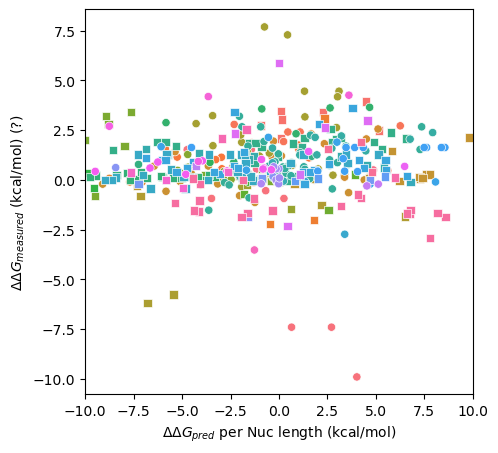

In [80]:
# use seaborn to make a scatter plot of ddG_per vs ddG_measured
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
# color by uniprot_id
# use squares if nuc_type is 'DNA' and circles if nuc_type is 'RNA'
sns.scatterplot(data=results_df,x='ddG_per',y='ddG_measured',hue='uniprot_id',style='nuc_type',markers={'DNA':'s','RNA':'o'})
#set x range to -10,10
plt.xlim(-10,10)
#turn of legend
plt.legend().remove()
plt.xlabel("$\Delta \Delta G_{pred}$ per Nuc length (kcal/mol)")
plt.ylabel("$\Delta \Delta G_{measured}$ (kcal/mol) (?)")
#plt.yticks(np.arange(-10,10,2))